In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade

In [2]:
%%time

import gc
import os
import string
import re
import warnings
warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay)
from keras_core.optimizers import Adam
from keras_core.losses import SparseCategoricalCrossentropy
from keras_nlp.models import DistilBertClassifier, DistilBertPreprocessor
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

Using TensorFlow backend
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 8.01 s, sys: 1.5 s, total: 9.51 s
Wall time: 17.5 s


True

In [3]:
class Cfg:
    # DataFrames
    train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', index_col=0)
    test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
    sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
    
    # TF-IDF
    feature = 'text'
    target = 'target'
    language = 'english'
    stop_words = stopwords.words('english')
    punct = string.punctuation
    
    # Test size & Seed
    seed = 42
    test_size = 0.2
    
    # DL
    model = "distil_bert_base_en_uncased"
    batch_size = 32
    n_epochs = 2
    lr = 1e-5
    n_classes = 2
    seq_length = 150
    metrics = ["accuracy"]

In [4]:
%%time
df = Cfg.train

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs


In [5]:
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


CPU times: user 25.1 ms, sys: 5.82 ms, total: 31 ms
Wall time: 35.9 ms


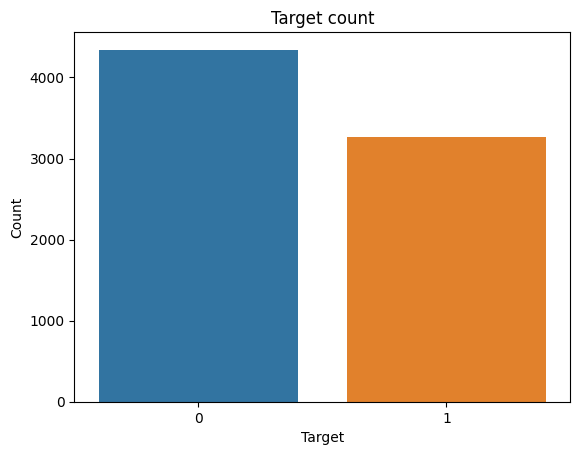

In [6]:
%%time
ax = sns.countplot(df, x=Cfg.target);
ax.set_title('Target count');
ax.set_xlabel('Target');
ax.set_ylabel('Count');

CPU times: user 935 ms, sys: 14.3 ms, total: 949 ms
Wall time: 947 ms


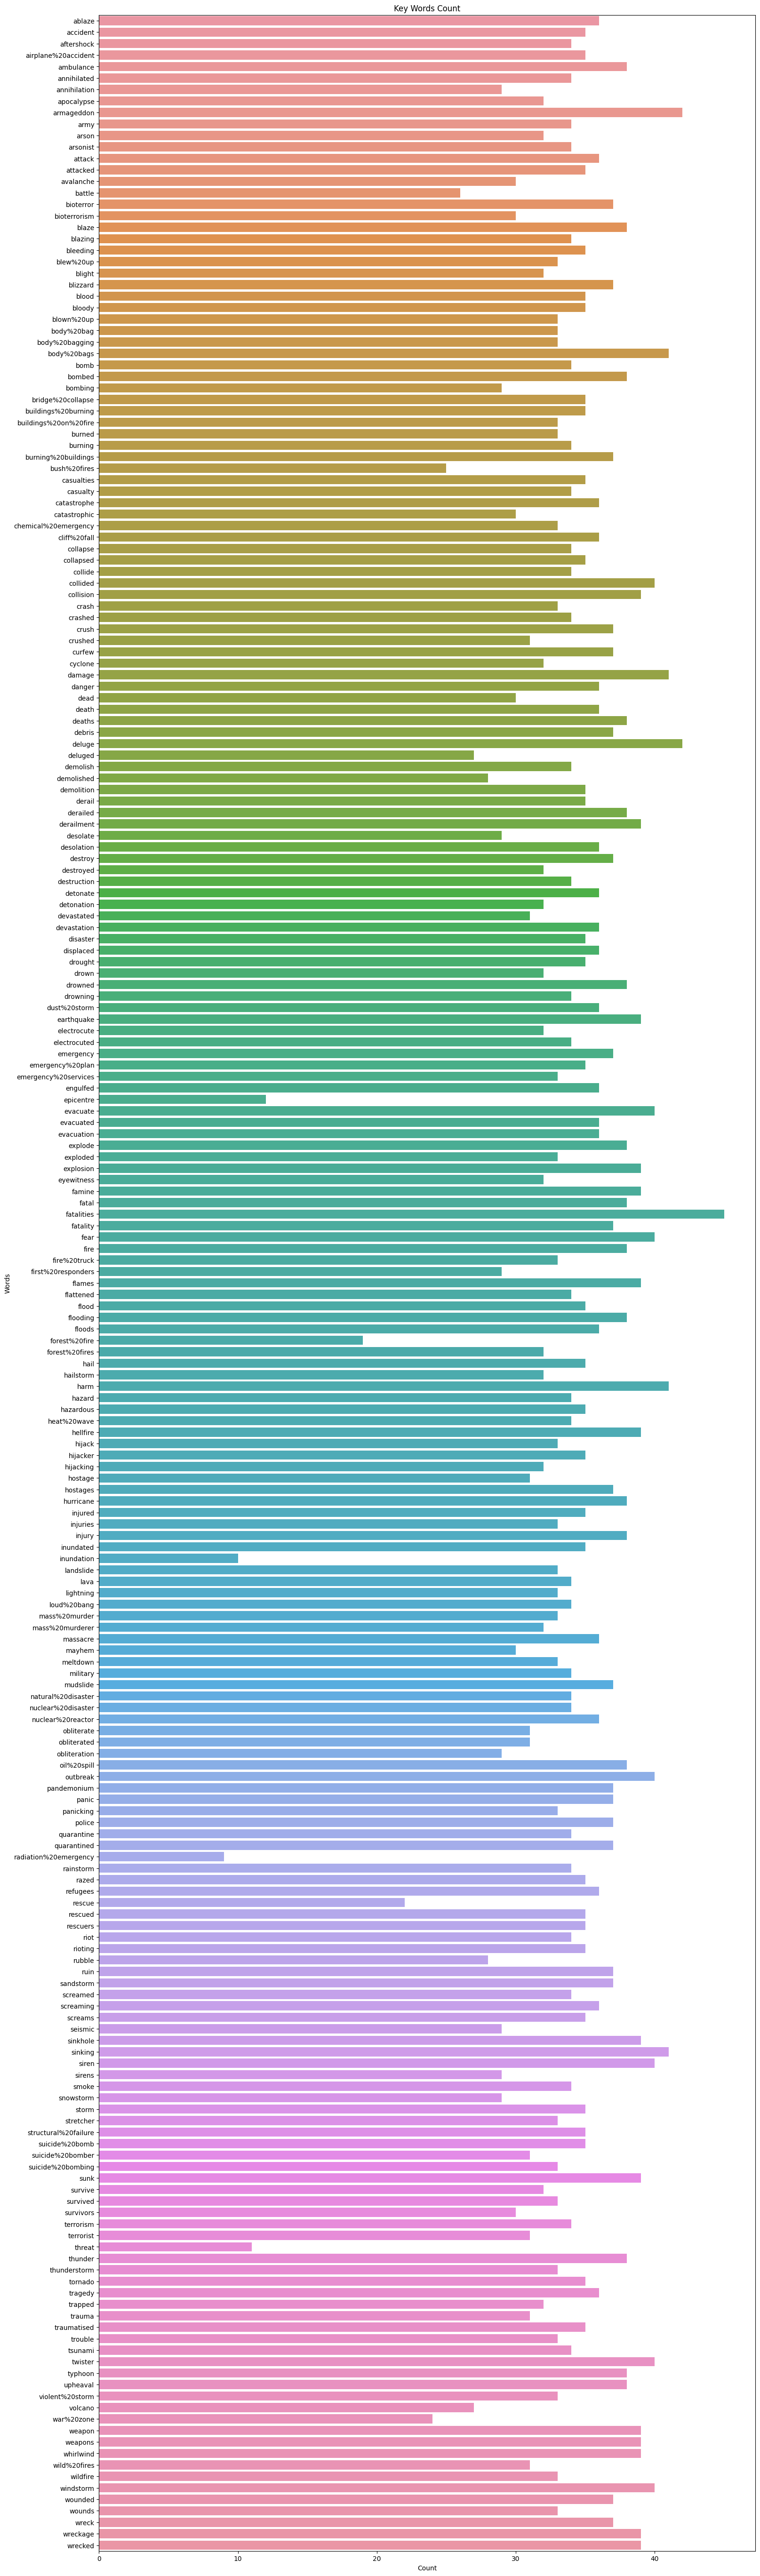

In [7]:
%%time
fig, ax = plt.subplots(figsize=(18, 70))
ax = sns.countplot(df, y='keyword', orient='h');
ax.set_title('Key Words Count');
ax.set_xlabel('Count');
ax.set_ylabel('Words');

In [8]:
sentence_example = df.iloc[1][Cfg.feature]
tokens = word_tokenize(sentence_example, language=Cfg.language)
tokens_no_punctuation = [i.lower() for i in tokens if i not in Cfg.punct]
stop_words = Cfg.stop_words
tokens_no_punctuation_and_stopwords = [i for i in tokens_no_punctuation if i not in stop_words]

In [9]:
def tokenize(sentence: str):
    tokens = word_tokenize(sentence, language=Cfg.language)
    tokens = [i.lower() for i in tokens if i not in Cfg.punct]
    stop_words = Cfg.stop_words
    tokens = [i for i in tokens if i not in stop_words]
    return tokens

In [10]:
print(f'Initial sentence: {sentence_example}')
print('-----------------------------')
print(f'Tokens with no punctuation and stopwords: {tokenize(sentence_example)}')

Initial sentence: Forest fire near La Ronge Sask. Canada
-----------------------------
Tokens with no punctuation and stopwords: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']


In [11]:
%%time
train_df, val_df = train_test_split(df, test_size=Cfg.test_size, 
                                    shuffle=True, random_state=Cfg.seed)

CPU times: user 1.43 ms, sys: 2.09 ms, total: 3.51 ms
Wall time: 3.1 ms


## TF-IDF Baseline

In [12]:
%%time
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize(x))
features = vectorizer.fit_transform(train_df[Cfg.feature])
features_val = vectorizer.transform(val_df[Cfg.feature])

CPU times: user 2.62 s, sys: 3.47 ms, total: 2.63 s
Wall time: 2.64 s


In [13]:
%%time
model_pipeline = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize(x))),
                           ('model', LogisticRegression(random_state=Cfg.seed))])
model_pipeline.fit(train_df[Cfg.feature], train_df[Cfg.target])
tf_idf_preds = model_pipeline.predict(val_df[Cfg.feature])

CPU times: user 3.59 s, sys: 1.11 s, total: 4.7 s
Wall time: 3.14 s


In [14]:
print(f"TF-IDF accuracy score: {accuracy_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF precision score: {precision_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF recall score: {recall_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF f1 score: {f1_score(val_df[Cfg.target], tf_idf_preds)}")

TF-IDF accuracy score: 0.788575180564675
-----------------------------
TF-IDF precision score: 0.7883597883597884
-----------------------------
TF-IDF recall score: 0.6887519260400616
-----------------------------
TF-IDF f1 score: 0.7351973684210527


CPU times: user 46.5 ms, sys: 901 µs, total: 47.4 ms
Wall time: 47.1 ms


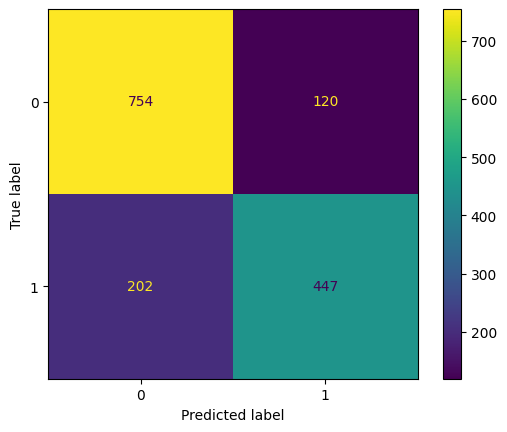

In [15]:
%%time
ConfusionMatrixDisplay.from_predictions(val_df[Cfg.target], tf_idf_preds);

In [16]:
%%time
sample = Cfg.sample
sample.head()

CPU times: user 125 µs, sys: 0 ns, total: 125 µs
Wall time: 129 µs


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
%%time
test = Cfg.test

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


In [18]:
%%time
sample[Cfg.target] = model_pipeline.predict(test[Cfg.feature])
sample.to_csv('tf_idf_submission.csv', index=False)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


## DistilBERT

In [19]:
%%time
preprocessor = DistilBertPreprocessor.from_preset(Cfg.model, 
                                                  sequence_length=Cfg.seq_length)
distilbert = DistilBertClassifier.from_preset(Cfg.model, 
                                              preprocessor=preprocessor, 
                                              num_classes=Cfg.n_classes)
distilbert.summary()

231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 3.2 s, sys: 1.69 s, total: 4.89 s
Wall time: 8.67 s


In [20]:
%%time
distilbert.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(Cfg.lr),
    metrics=Cfg.metrics  
)

history = distilbert.fit(x=train_df[Cfg.feature],
                         y=train_df[Cfg.target],
                         batch_size=Cfg.batch_size,
                         epochs=Cfg.n_epochs, 
                         validation_data=(val_df[Cfg.feature],
                                          val_df[Cfg.target])
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 142s 530ms/step - accuracy: 0.7117 - loss: 0.5676 - val_accuracy: 0.8464 - val_loss: 0.3955
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 80s 417ms/step - accuracy: 0.8447 - loss: 0.3799 - val_accuracy: 0.8477 - val_loss: 0.3837
CPU times: user 3min 43s, sys: 1.89 s, total: 3min 45s
Wall time: 3min 49s


In [21]:
%%time
y_pred_train = distilbert.predict(train_df[Cfg.feature])
y_pred_val = distilbert.predict(val_df[Cfg.feature])

191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step
CPU times: user 12.3 s, sys: 410 ms, total: 12.7 s
Wall time: 38.8 s


In [22]:
print(f"DistilBERT accuracy score: {accuracy_score(val_df[Cfg.target], np.argmax(y_pred_val, axis=1))}")
print('-----------------------------')
print(f"DistilBERT precision score: {precision_score(val_df[Cfg.target], np.argmax(y_pred_val, axis=1))}")
print('-----------------------------')
print(f"DistilBERT recall score: {recall_score(val_df[Cfg.target], np.argmax(y_pred_val, axis=1))}")
print('-----------------------------')
print(f"DistilBERT f1 score: {f1_score(val_df[Cfg.target], np.argmax(y_pred_val, axis=1))}")

DistilBERT accuracy score: 0.8476690741956664
-----------------------------
DistilBERT precision score: 0.8651488616462347
-----------------------------
DistilBERT recall score: 0.7611710323574731
-----------------------------
DistilBERT f1 score: 0.8098360655737705


CPU times: user 49.3 ms, sys: 0 ns, total: 49.3 ms
Wall time: 49 ms


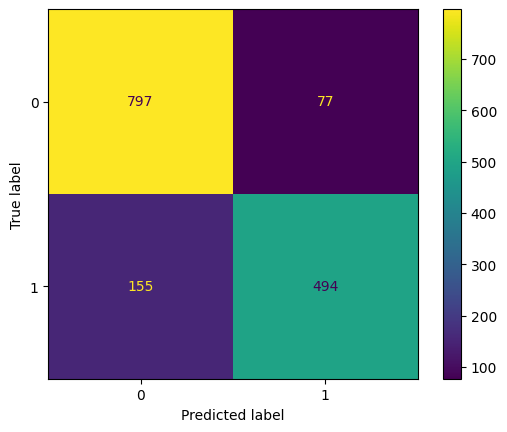

In [23]:
%%time
ConfusionMatrixDisplay.from_predictions(val_df[Cfg.target], np.argmax(y_pred_val, axis=1));

In [24]:
%%time
sample[Cfg.target] = np.argmax(distilbert.predict(test[Cfg.feature]), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step
CPU times: user 4.79 s, sys: 167 ms, total: 4.96 s
Wall time: 16 s


In [25]:
%%time
sample.to_csv("distilbert_submission.csv", index=False)

CPU times: user 7.78 ms, sys: 1.03 ms, total: 8.81 ms
Wall time: 8.44 ms
